Overview

Customer segmentation involves categorizing your customers into smaller groups based on shared characteristics such as buying habits or demographics. This helps retailers gain deeper insights into their customer base, enabling them to tailor their marketing strategies and products to meet each group's specific needs. 

By employing customer segmentation, companies can enhance customer satisfaction, improve targeting accuracy, and optimize resource allocation, ultimately leading to increased profitability and competitiveness in the market.

In this notebook, we'll explore a few basic customer segmentations. 

### Setup

Here we'll create some simulated data to demonstrate the code. You do not need to know this to perform segmentations.

In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import strictyaml as yaml

from pyretailscience.data.simulation import Simulation, config_schema

config_file = "../../data/default_data_config.yaml"
with open(config_file, "r") as f:
    config = yaml.load(f.read(), config_schema).data

config["transactions"]["start_date"] = datetime(year=2023, month=1, day=1)
sim = Simulation(seed=42, config=config)
sim.run()
df = pd.DataFrame(sim.transactions)
df.head(3)

Simulating days: 100%|██████████| 364/364 [00:58<00:00,  6.21it/s]


,transaction_id,transaction_datetime,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_price,quantity,total_price,store_id
0,11122,2023-01-08 13:57:07,1,575,Athletic Taper Jean,Clothing,4,Jeans,23,Calvin Klein,115,92.00,3,276.00,5
1,18026,2023-02-02 11:32:54,1,441,Fire HD 10,Electronics,3,Tablets,18,Amazon,89,149.99,3,449.97,2
2,18026,2023-02-02 11:32:54,1,329,Bacon,Grocery,2,Meat & Seafood,14,Oscar Mayer,66,5.99,4,23.96,2


Some details about the data

In [ ]:
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Number of unique transactions: {df['transaction_id'].nunique()}")

Number of unique customers: 4239
Number of unique transactions: 25411


## Heavy / Medium / Light

Heavy, Medium, Light (HML) is a segmentation that places customers into groups based on the their percentile of spend or the number of products they bought. Heavy customers are the top 20% of customers, medium are the next 30%, and light are the bottom 50% of customers. These values are chosen based on the proportions of the Pareto distribution. Often, purchase behaviour follows this distribution. This is typified by the expression 20% of your customers generate 80% of your sales.

You would use a HML segmentation to answer question such as these,

* How much more are your best customers worth?
* How much more could I spend acquiring my best customers?
* What is the concentration of sales with my top (heavy) customers?

Using PyRetailScience it takes only one line of code to get HML segments.

In [ ]:
from pyretailscience.segmentation import HMLSegmentation

seg = HMLSegmentation(df, zero_value_customers="include_with_light")
seg.df.head()

,total_price,segment_name,segment_id
customer_id,,,
1,9329.84,Light,L
2,2258.80,Light,L
3,75.96,Light,L
4,8505.98,Light,L
5,38751.12,Heavy,H


We can then attach those segments back to the original dataframe. You can see these segments to the very right of the dataframe.

In [ ]:
df_with_segments = seg.add_segment(df)
df_with_segments.head()

,transaction_id,transaction_datetime,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_price,quantity,total_price,store_id,segment_name,segment_id
0,11122,2023-01-08 13:57:07,1,575,Athletic Taper Jean,Clothing,4,Jeans,23,Calvin Klein,115,92.00,3,276.00,5,Light,L
1,18026,2023-02-02 11:32:54,1,441,Fire HD 10,Electronics,3,Tablets,18,Amazon,89,149.99,3,449.97,2,Light,L
2,18026,2023-02-02 11:32:54,1,329,Bacon,Grocery,2,Meat & Seafood,14,Oscar Mayer,66,5.99,4,23.96,2,Light,L
3,18026,2023-02-02 11:32:54,1,1202,Gentle Skin Cleanser,Beauty,7,Body Care,48,Cetaphil,241,14.99,0,0.00,2,Light,L
4,18026,2023-02-02 11:32:54,1,1759,CVA-400 Viola,Music,10,String Instruments,70,Cecilio,352,199.99,0,0.00,2,Light,L


Now it's only one line of code to get standard KPIs on each customer segment. This makes segment comparison easy.

In [ ]:
from pyretailscience.segmentation import SegTransactionStats

seg_stats = SegTransactionStats(df_with_segments, segment_col="segment_name")
seg_stats.df

,revenue,transactions,customers,total_quantity,price_per_unit,quantity_per_transaction,spend_per_cust,spend_per_transaction,transactions_per_customer,customers_pct
segment_name,,,,,,,,,,
Light,8579677.95,7451,2120,48381,177.335689,6.493222,4047.017901,1151.480063,3.514623,0.500118
Medium,23475088.60,9809,1271,72311,324.640630,7.371903,18469.778600,2393.219350,7.717545,0.299835
Heavy,41721527.45,8151,848,65959,632.537295,8.092136,49199.914446,5118.577776,9.612028,0.200047


We can quickly get a bar plot to compare any of the values using the `plot` function. With a few extra lines of code, we can dress up the plot with a callout. Now the chart highlights how much more valuable Heavy customers are compared to the Light ones.

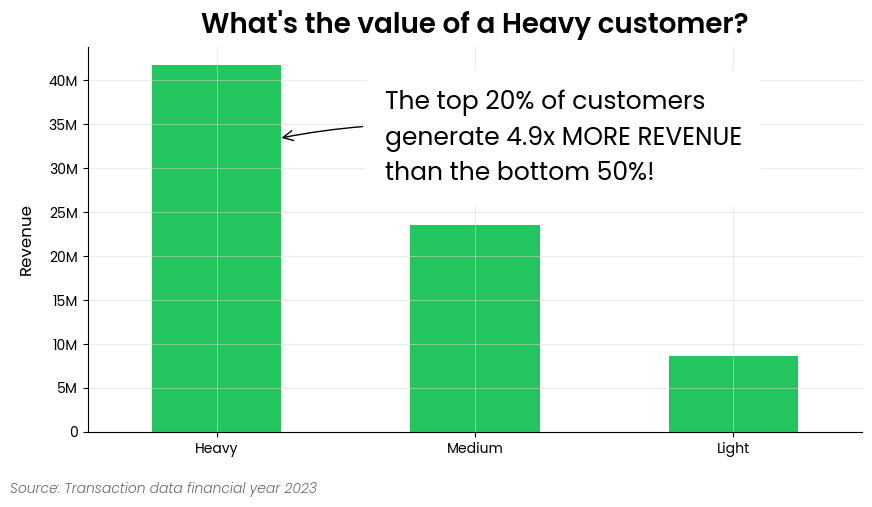

In [ ]:
from pyretailscience.style.graph_utils import GraphStyles as gs

ax = seg_stats.plot(
    figsize=(10, 5),
    value_col="revenue",
    source_text="Source: Transaction data financial year 2023",
    sort_order="descending",
    title="What's the value of a Heavy customer?",
    rot=0,
)

# Dress up the plot with an arrow calling out the important point
heavy_rev = seg_stats.df.loc["Heavy", "revenue"]
light_rev = seg_stats.df.loc["Light", "revenue"]
h_vs_l_rev = heavy_rev / light_rev

ax.annotate(
    f"The top 20% of customers\ngenerate {h_vs_l_rev:.1f}x MORE REVENUE\nthan the bottom 50%!",
    xy=(0.24, heavy_rev * 0.8),
    xytext=(0.65, heavy_rev * 0.8),
    fontsize=18,
    fontproperties=gs.POPPINS_REG,
    ha="left",
    va="center",
    arrowprops=dict(
        facecolor="white",
        arrowstyle="->",
        connectionstyle="arc3,rad=0.1",
    ),
    color="black",
    bbox=dict(
        facecolor="white",
        edgecolor="white",
        boxstyle="round,rounding_size=0.75",
        pad=0.75,
    ),
    linespacing=1.5,
)
# plt.gcf().set_dpi(300)
plt.savefig("monthly_active_customers.svg")
plt.show()

Getting a plot of the segment's activity over time is also now a snap.

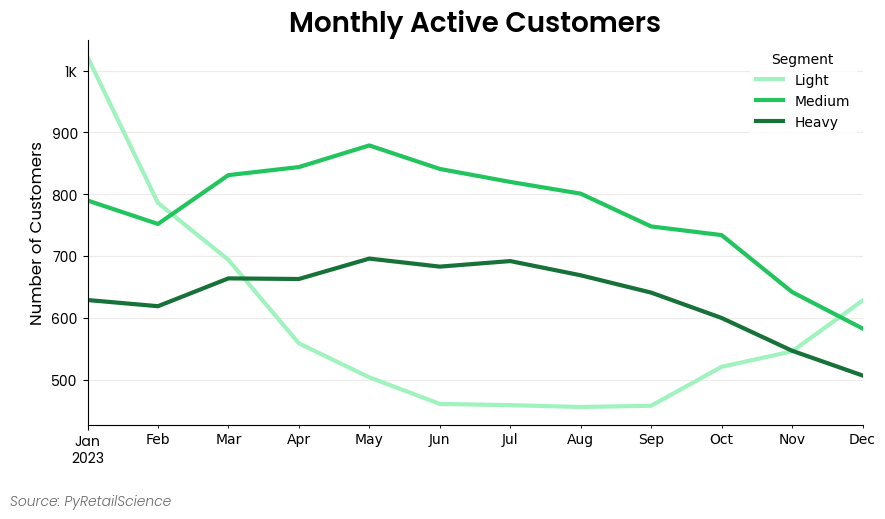

In [ ]:
from pyretailscience.standard_graphs import time_plot

df_with_groups = seg.add_segment(df)
time_plot(
    df_with_groups,
    figsize=(10, 5),
    period="M",
    group_col="segment_name",
    value_col="customer_id",
    agg_func="nunique",
    title="Monthly Active Customers",
    y_label="Number of Customers",
    source_text="Source: PyRetailScience",
)
plt.show()

## Activating

Once you have your segments, you will often want to activate them. It is easy to export them to a CSV for activation in your CRM or with platforms.


In [ ]:
filename = "heavy_customers.csv"
seg.df[seg.df["segment_name"] == "Heavy"].index.to_series().to_csv(filename, index=False)

# Display the CSV
with open(filename, "r") as f:
    print("".join(f.readlines()[:5]))

customer_id
5
7
8
14



## Coming soon

* Quickly segmenting new vs returning customers
* More charting options
* Activating segments to Facebook and other social platforms
* ... and more